In [3]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
import shutil

import librosa
import librosa.display
import IPython.display as ipd

from itertools import cycle

sns.set_theme(style="white", palette=None)
color_pal = plt.rcParams["axes.prop_cycle"].by_key()["color"]
color_cycle = cycle(plt.rcParams["axes.prop_cycle"].by_key()["color"])

In [2]:
# Read the CSV back into a DataFrame
combined_data_csv_path = "metadata.csv"
loaded_df = pd.read_csv(combined_data_csv_path)


In [3]:
loaded_df.head()

File Path            File Name Speaker ID     Label  \
0   bonafide\record-1020001.wav   record-1020001.wav     record  bonafide   
1  bonafide\record-10200010.wav  record-10200010.wav     record  bonafide   
2  bonafide\record-10200011.wav  record-10200011.wav     record  bonafide   
3  bonafide\record-10200012.wav  record-10200012.wav     record  bonafide   
4  bonafide\record-10200013.wav  record-10200013.wav     record  bonafide   

   Duration  
0       5.0  
1       5.0  
2       5.0  
3       5.0  
4       5.0

In [4]:
loaded_df.tail()

File Path          File Name Speaker ID  Label  Duration
27371  spoof\tts-030200095.wav  tts-030200095.wav        tts  spoof       5.0
27372  spoof\tts-030200096.wav  tts-030200096.wav        tts  spoof       5.0
27373  spoof\tts-030200097.wav  tts-030200097.wav        tts  spoof       5.0
27374  spoof\tts-030200098.wav  tts-030200098.wav        tts  spoof       5.0
27375  spoof\tts-030200099.wav  tts-030200099.wav        tts  spoof       5.0

In [5]:
# Filter for spoof and bonafide files
spoof_files = loaded_df[loaded_df['Label'] == 'spoof'].reset_index(drop=True)
bonafide_files = loaded_df[loaded_df['Label'] == 'bonafide'].reset_index(drop=True)

# Check the number of files in each category
print(f"Total number of spoof files: {len(spoof_files)}")
print(f"Total number of bonafide files: {len(bonafide_files)}")

Total number of spoof files: 14499
Total number of bonafide files: 12877


In [5]:
import librosa
import IPython.display as ipd

# Provide paths to the audio files directly
bonafide_audio_file = {
    'File Name': 'tramp-real.wav',
    'Label': 'bonafide',
    'File Path': 'tramp-real.wav'
}

spoof_audio_file = {
    'File Name': 'tramp-fake.wav',
    'Label': 'spoof',
    'File Path': 'tramp-fake.wav'
}

# Print details
print(f"[Bonafide] File Name: {bonafide_audio_file['File Name']} | Label: {bonafide_audio_file['Label']}")
print(f"[Spoof] File Name: {spoof_audio_file['File Name']} | Label: {spoof_audio_file['Label']}")

# Load the audio signals
bonafide_signal, bonafide_sample_rate = librosa.load(bonafide_audio_file['File Path'], sr=None)
spoof_signal, spoof_sample_rate = librosa.load(spoof_audio_file['File Path'], sr=None)

# Display audio players
print("\n🔊 Bonafide Audio Player:")
ipd.display(ipd.Audio(bonafide_signal, rate=bonafide_sample_rate))

print("\n🔊 Spoof Audio Player:")
ipd.display(ipd.Audio(spoof_signal, rate=spoof_sample_rate))


[Bonafide] File Name: tramp-real.wav | Label: bonafide
[Spoof] File Name: tramp-fake.wav | Label: spoof

🔊 Bonafide Audio Player:



🔊 Spoof Audio Player:


In [6]:
# Ensure both signals are trimmed and have same length
min_len = min(len(bonafide_signal), len(spoof_signal))
bonafide_signal = bonafide_signal[:min_len]
spoof_signal = spoof_signal[:min_len]

In [7]:
# Shared params
hop_length = 512
n_fft = 2048
n_mfcc = 13

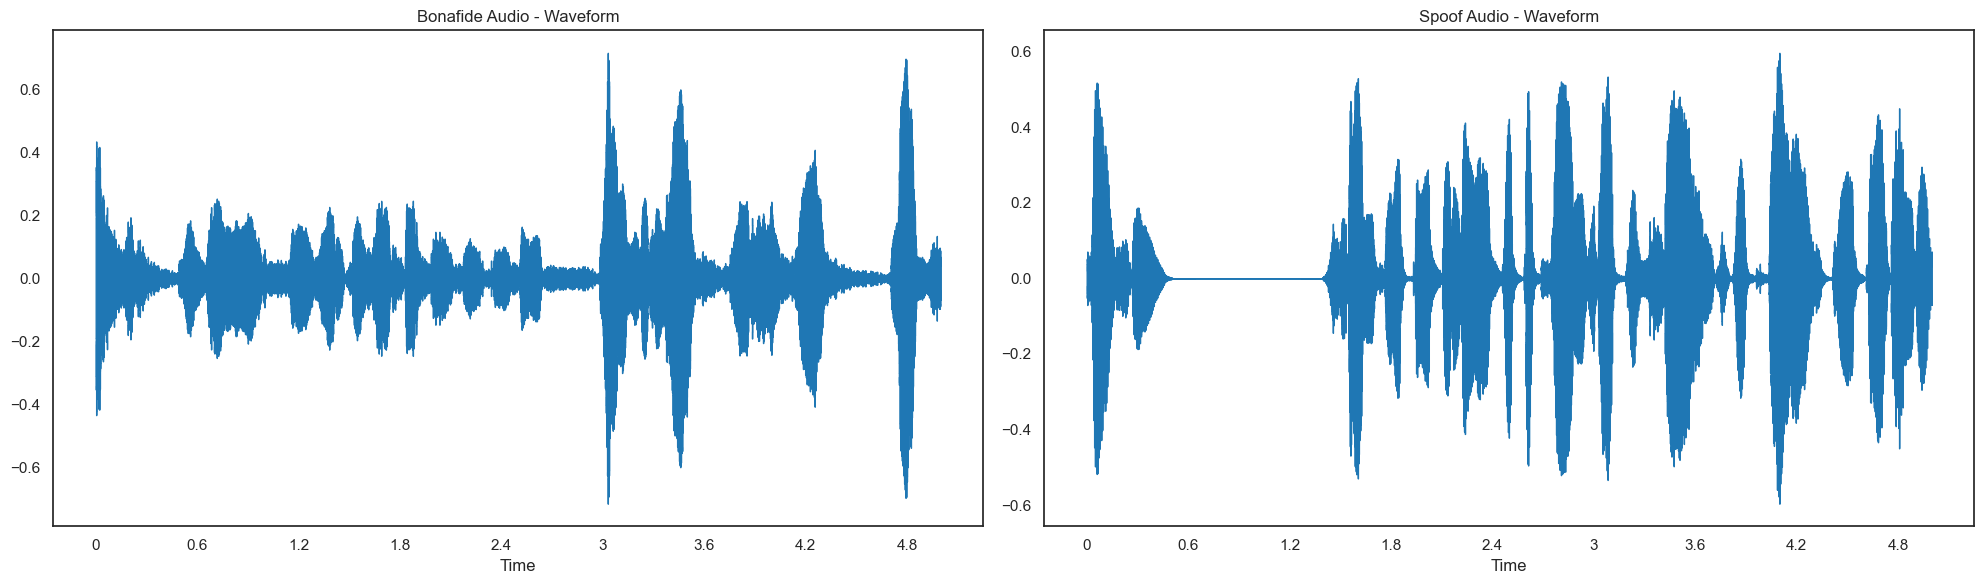

In [9]:
# 1. Waveform Plot
plt.figure(figsize=(20, 6))
plt.subplot(1, 2, 1)
librosa.display.waveshow(bonafide_signal, sr=bonafide_sample_rate)
plt.title("Bonafide Audio - Waveform")
plt.subplot(1, 2, 2)
librosa.display.waveshow(spoof_signal, sr=spoof_sample_rate)
plt.title("Spoof Audio - Waveform")
plt.tight_layout()
plt.show()

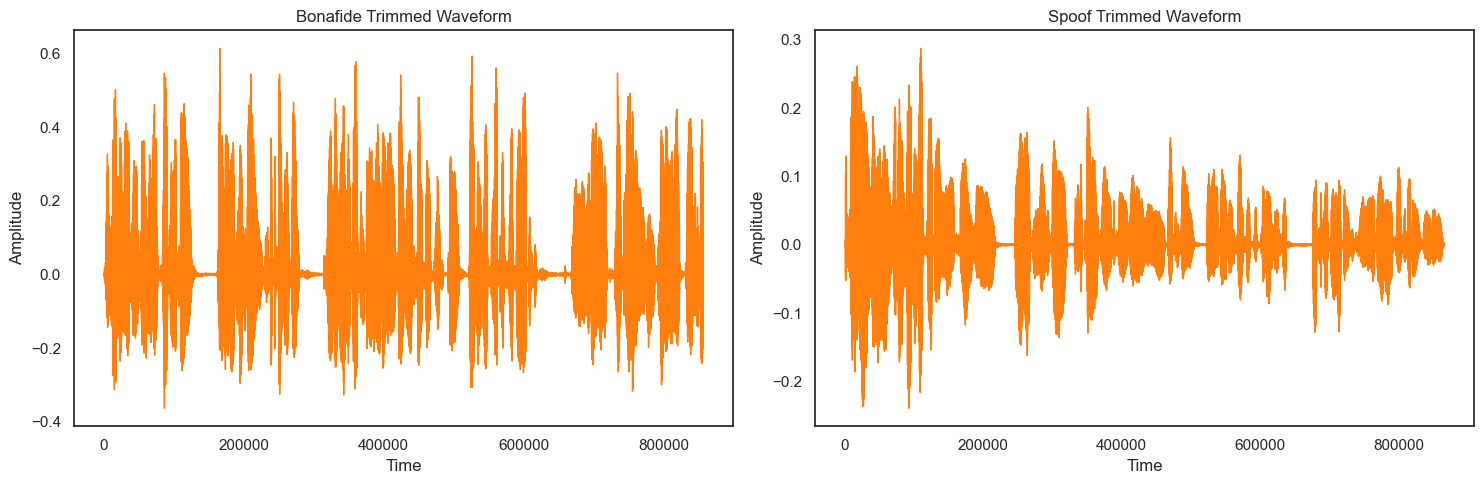

In [8]:
# Trim silence from both signals
bonafide_signal_trimmed, _ = librosa.effects.trim(y=bonafide_signal, top_db=40)
spoof_signal_trimmed, _ = librosa.effects.trim(y=spoof_signal, top_db=40)

# Plot trimmed waveforms side by side
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

pd.Series(bonafide_signal_trimmed).plot(ax=axes[0], lw=1, 
                                        title='Bonafide Trimmed Waveform', 
                                        color=color_pal[1])
axes[0].set_xlabel("Time")
axes[0].set_ylabel("Amplitude")

pd.Series(spoof_signal_trimmed).plot(ax=axes[1], lw=1, 
                                     title='Spoof Trimmed Waveform', 
                                     color=color_pal[1])
axes[1].set_xlabel("Time")
axes[1].set_ylabel("Amplitude")

plt.tight_layout()
plt.show()


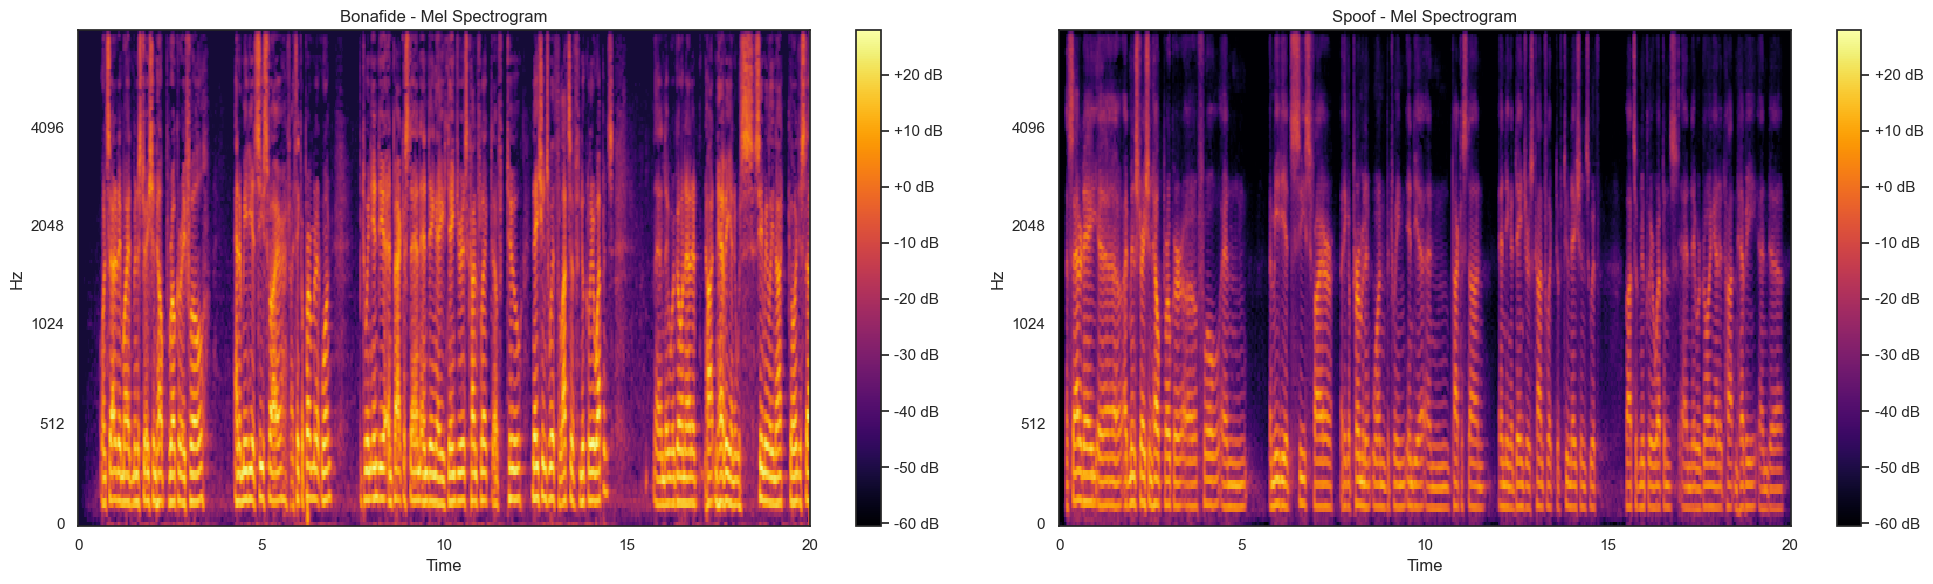

In [ ]:
# Ensure consistent sample rates
bonafide_signal = librosa.resample(bonafide_signal, orig_sr=bonafide_sample_rate, target_sr=16000)
spoof_signal = librosa.resample(spoof_signal, orig_sr=spoof_sample_rate, target_sr=16000)

# Compute Mel spectrograms with fixed params
n_fft, hop_length = 2048, 512
S_bonafide = librosa.feature.melspectrogram(y=bonafide_signal, sr=16000, n_fft=n_fft, hop_length=hop_length)
S_spoof = librosa.feature.melspectrogram(y=spoof_signal, sr=16000, n_fft=n_fft, hop_length=hop_length)

# Convert to dB with sync scaling
S_db_bonafide = librosa.power_to_db(S_bonafide, ref=1.0, amin=1e-10, top_db=80)
S_db_spoof = librosa.power_to_db(S_spoof, ref=1.0, amin=1e-10, top_db=80)

# Plot with aligned colorbars
plt.figure(figsize=(20, 6))
vmin, vmax = np.min([S_db_bonafide.min(), S_db_spoof.min()]), np.max([S_db_bonafide.max(), S_db_spoof.max()])

plt.subplot(1, 2, 1)
librosa.display.specshow(S_db_bonafide, sr=16000, hop_length=hop_length, 
                         x_axis='time', y_axis='mel', cmap='inferno', 
                         vmin=vmin, vmax=vmax)
plt.title("Bonafide - Mel Spectrogram")
plt.colorbar(format='%+2.0f dB')

plt.subplot(1, 2, 2)
librosa.display.specshow(S_db_spoof, sr=16000, hop_length=hop_length, 
                         x_axis='time', y_axis='mel', cmap='inferno', 
                         vmin=vmin, vmax=vmax)
plt.title("Spoof - Mel Spectrogram")
plt.colorbar(format='%+2.0f dB')

plt.tight_layout()
plt.show()

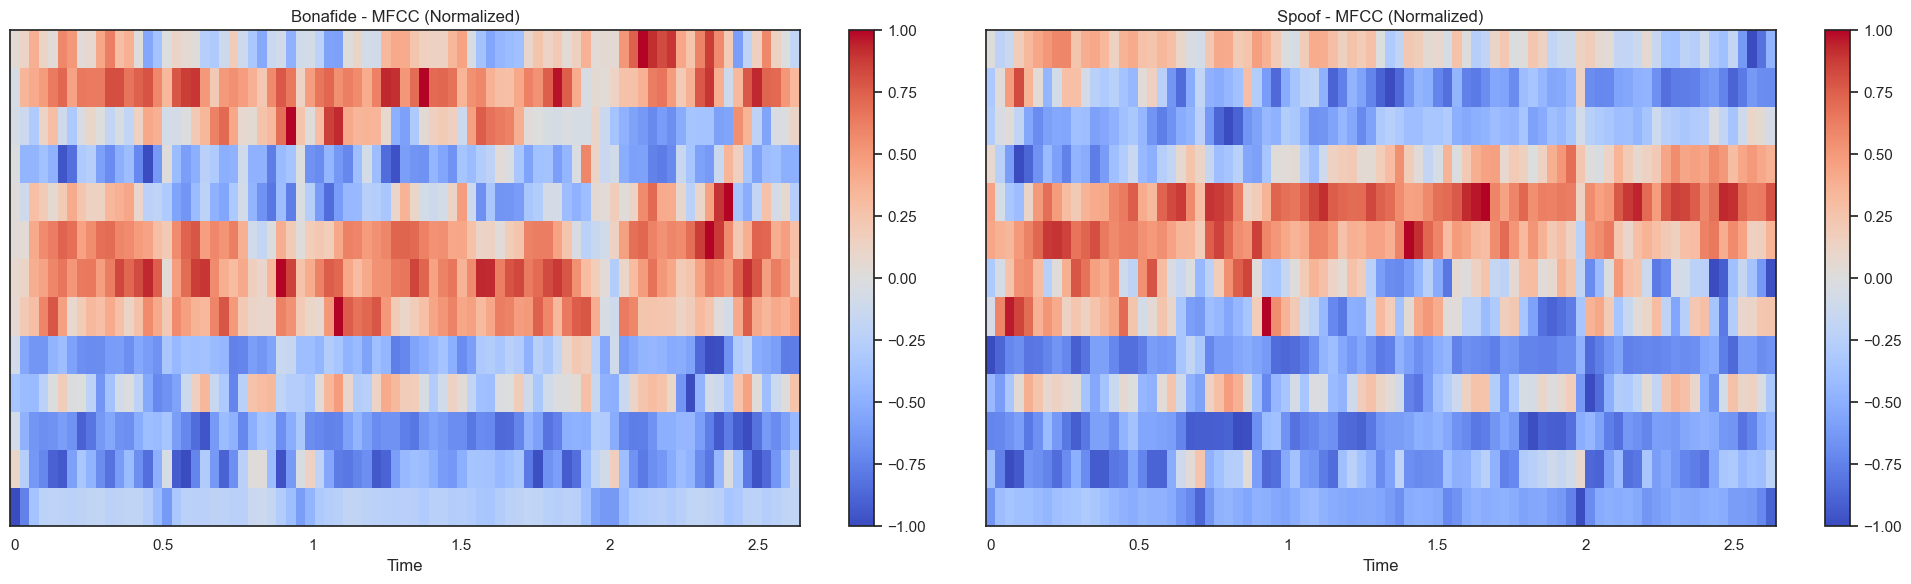

In [ ]:
# Compute MFCCs with fixed parameters
n_fft, hop_length, n_mfcc = 2048, 512, 13  # Standard 13 MFCCs
mfcc_bonafide = librosa.feature.mfcc(y=bonafide_signal, sr=16000, n_fft=n_fft, 
                                    hop_length=hop_length, n_mfcc=n_mfcc)
mfcc_spoof = librosa.feature.mfcc(y=spoof_signal, sr=16000, n_fft=n_fft, 
                                 hop_length=hop_length, n_mfcc=n_mfcc)

# Normalize MFCCs (optional but recommended for visualization)
mfcc_bonafide = librosa.util.normalize(mfcc_bonafide, axis=1)
mfcc_spoof = librosa.util.normalize(mfcc_spoof, axis=1)

# Plot with aligned colorbars
plt.figure(figsize=(20, 6))
vmin, vmax = np.min([mfcc_bonafide.min(), mfcc_spoof.min()]), np.max([mfcc_bonafide.max(), mfcc_spoof.max()])

plt.subplot(1, 2, 1)
librosa.display.specshow(mfcc_bonafide, x_axis='time', sr=16000, hop_length=hop_length,
                        cmap='coolwarm', vmin=vmin, vmax=vmax)
plt.title("Bonafide - MFCC (Normalized)")
plt.colorbar()

plt.subplot(1, 2, 2)
librosa.display.specshow(mfcc_spoof, x_axis='time', sr=16000, hop_length=hop_length,
                        cmap='coolwarm', vmin=vmin, vmax=vmax)
plt.title("Spoof - MFCC (Normalized)")
plt.colorbar()

plt.tight_layout()
plt.savefig('mfcc_compare.png', dpi=300)  # Optional: Save for reports
plt.show()

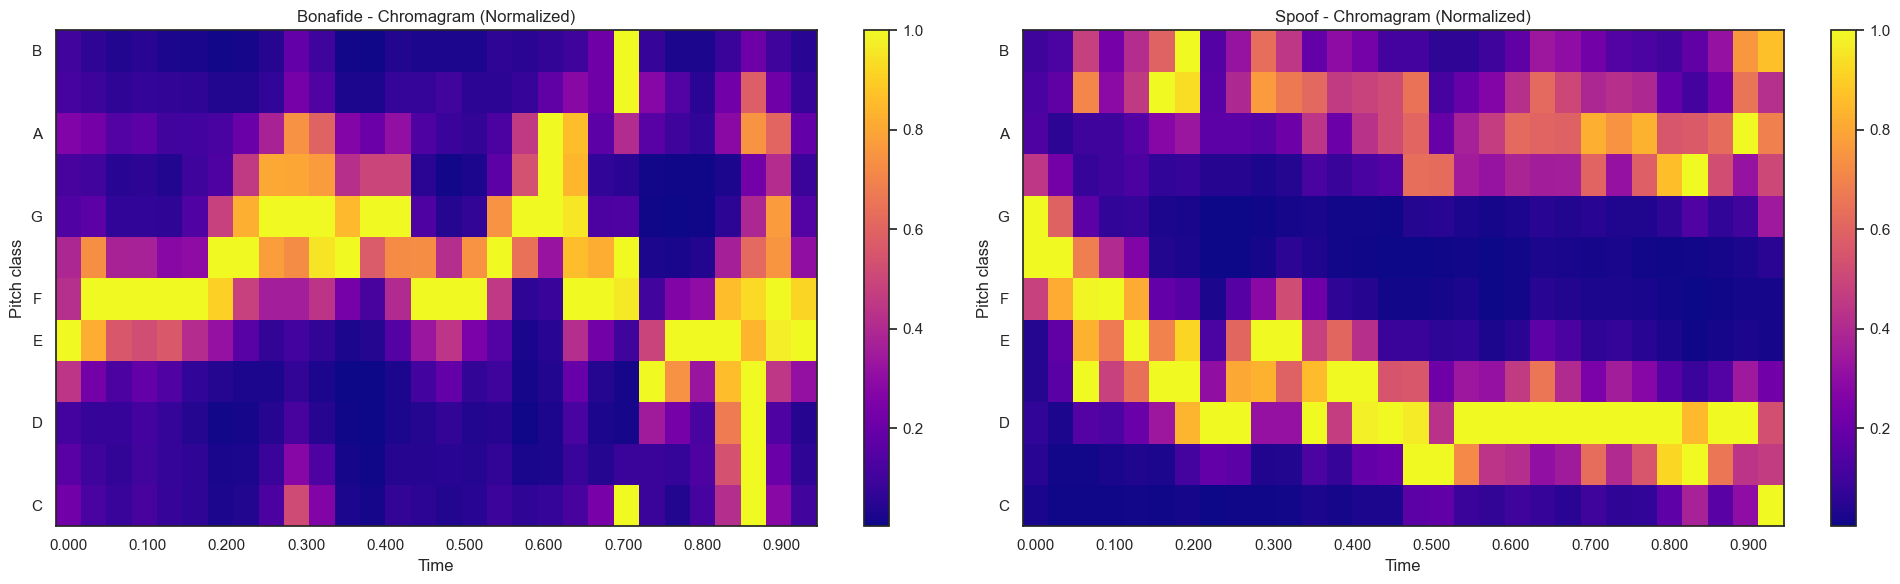

In [ ]:
# Compute chromagrams with fixed parameters
hop_length = 512
chroma_bonafide = librosa.feature.chroma_stft(y=bonafide_signal, sr=16000, hop_length=hop_length)
chroma_spoof = librosa.feature.chroma_stft(y=spoof_signal, sr=16000, hop_length=hop_length)

# Normalize chroma energy (optional but recommended)
chroma_bonafide = librosa.util.normalize(chroma_bonafide, axis=1)
chroma_spoof = librosa.util.normalize(chroma_spoof, axis=1)

# Plot with aligned colorbars
plt.figure(figsize=(20, 6))
vmin, vmax = np.min([chroma_bonafide.min(), chroma_spoof.min()]), np.max([chroma_bonafide.max(), chroma_spoof.max()])

plt.subplot(1, 2, 1)
librosa.display.specshow(chroma_bonafide, x_axis='time', y_axis='chroma', 
                        sr=16000, hop_length=hop_length, cmap='plasma',
                        vmin=vmin, vmax=vmax)
plt.title("Bonafide - Chromagram (Normalized)")
plt.colorbar()

plt.subplot(1, 2, 2)
librosa.display.specshow(chroma_spoof, x_axis='time', y_axis='chroma',
                        sr=16000, hop_length=hop_length, cmap='plasma',
                        vmin=vmin, vmax=vmax)
plt.title("Spoof - Chromagram (Normalized)")
plt.colorbar()

plt.tight_layout()
plt.show()

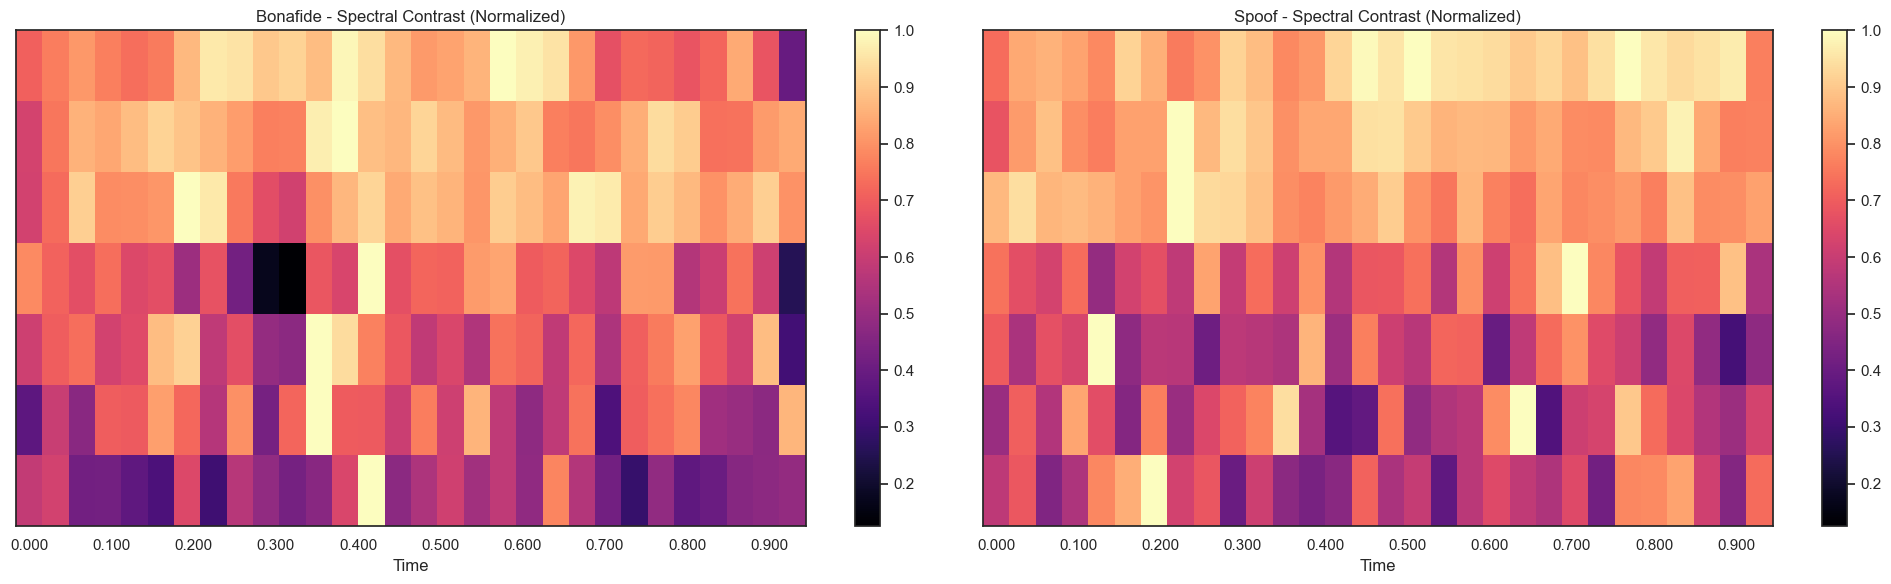

In [29]:
# Compute Spectral Contrast with consistent parameters
n_fft, hop_length = 2048, 512
contrast_bonafide = librosa.feature.spectral_contrast(y=bonafide_signal, sr=16000, 
                                                     n_fft=n_fft, hop_length=hop_length)
contrast_spoof = librosa.feature.spectral_contrast(y=spoof_signal, sr=16000,
                                                  n_fft=n_fft, hop_length=hop_length)

# Normalize for better visualization
contrast_bonafide = librosa.util.normalize(contrast_bonafide, axis=1)
contrast_spoof = librosa.util.normalize(contrast_spoof, axis=1)

# Plot with synchronized scaling
plt.figure(figsize=(20, 6))
vmin, vmax = np.min([contrast_bonafide.min(), contrast_spoof.min()]), \
             np.max([contrast_bonafide.max(), contrast_spoof.max()])

plt.subplot(1, 2, 1)
librosa.display.specshow(contrast_bonafide, x_axis='time', sr=16000,
                        hop_length=hop_length, cmap='magma',
                        vmin=vmin, vmax=vmax)
plt.title("Bonafide - Spectral Contrast (Normalized)")
plt.colorbar()

plt.subplot(1, 2, 2)
librosa.display.specshow(contrast_spoof, x_axis='time', sr=16000,
                        hop_length=hop_length, cmap='magma',
                        vmin=vmin, vmax=vmax)
plt.title("Spoof - Spectral Contrast (Normalized)")
plt.colorbar()

plt.tight_layout()
plt.savefig('spectral_contrast_compare.png', dpi=300)
plt.show()

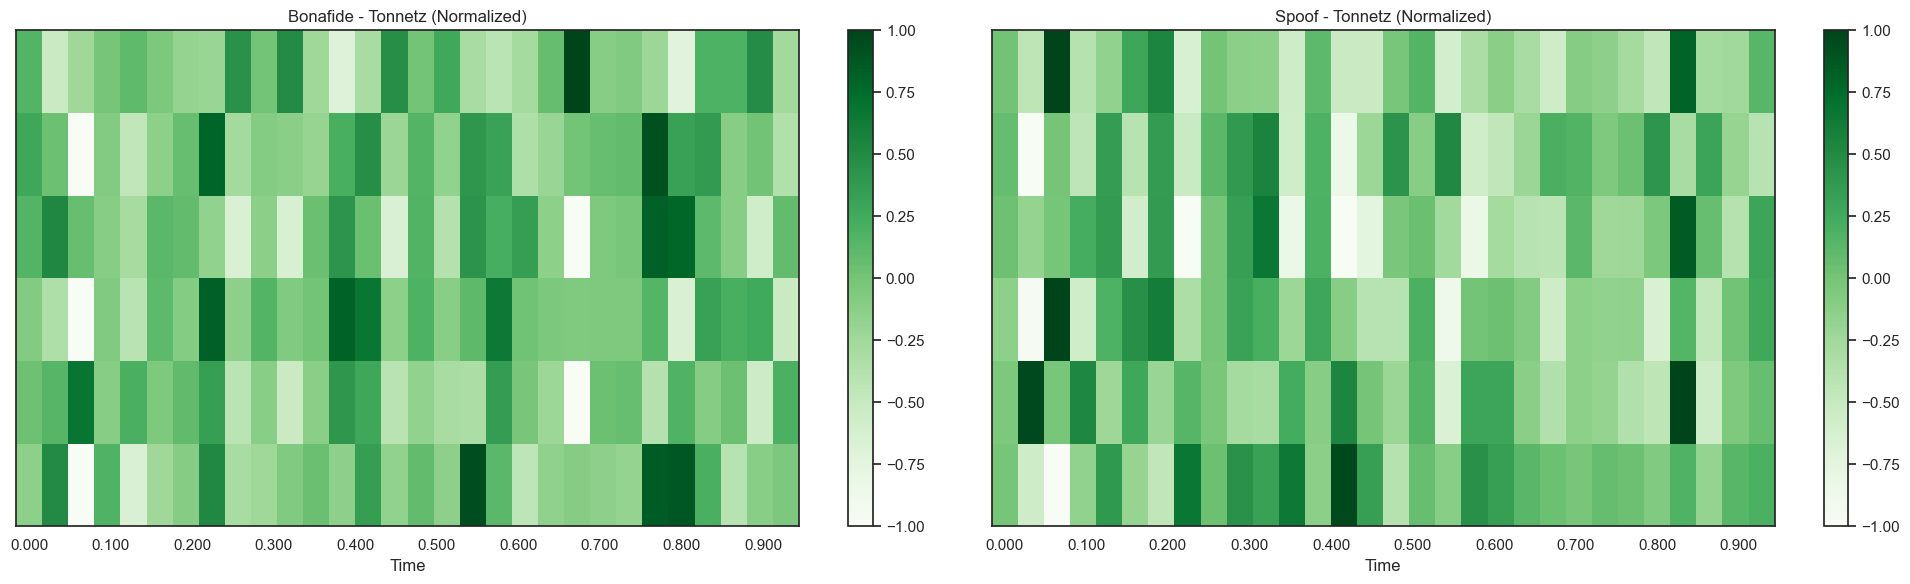

In [36]:
# Step 1: Compute chroma first (Tonnetz needs chroma input internally)
chroma_bonafide = librosa.feature.chroma_cqt(y=bonafide_signal, sr=16000, hop_length=hop_length)
chroma_spoof = librosa.feature.chroma_cqt(y=spoof_signal, sr=16000, hop_length=hop_length)

# Step 2: Compute Tonnetz from chroma
tonnetz_bonafide = librosa.feature.tonnetz(chroma=chroma_bonafide, sr=16000)
tonnetz_spoof = librosa.feature.tonnetz(chroma=chroma_spoof, sr=16000)

# Step 3: Normalize
tonnetz_bonafide = librosa.util.normalize(tonnetz_bonafide, axis=1)
tonnetz_spoof = librosa.util.normalize(tonnetz_spoof, axis=1)

# Step 4: Plot
plt.figure(figsize=(20, 6))
vmin, vmax = np.min([tonnetz_bonafide.min(), tonnetz_spoof.min()]), \
             np.max([tonnetz_bonafide.max(), tonnetz_spoof.max()])

plt.subplot(1, 2, 1)
librosa.display.specshow(tonnetz_bonafide, x_axis='time', sr=16000,
                        hop_length=hop_length, cmap='Greens',
                        vmin=vmin, vmax=vmax)
plt.title("Bonafide - Tonnetz (Normalized)")
plt.colorbar()

plt.subplot(1, 2, 2)
librosa.display.specshow(tonnetz_spoof, x_axis='time', sr=16000,
                        hop_length=hop_length, cmap='Greens',
                        vmin=vmin, vmax=vmax)
plt.title("Spoof - Tonnetz (Normalized)")
plt.colorbar()

plt.tight_layout()
plt.show()


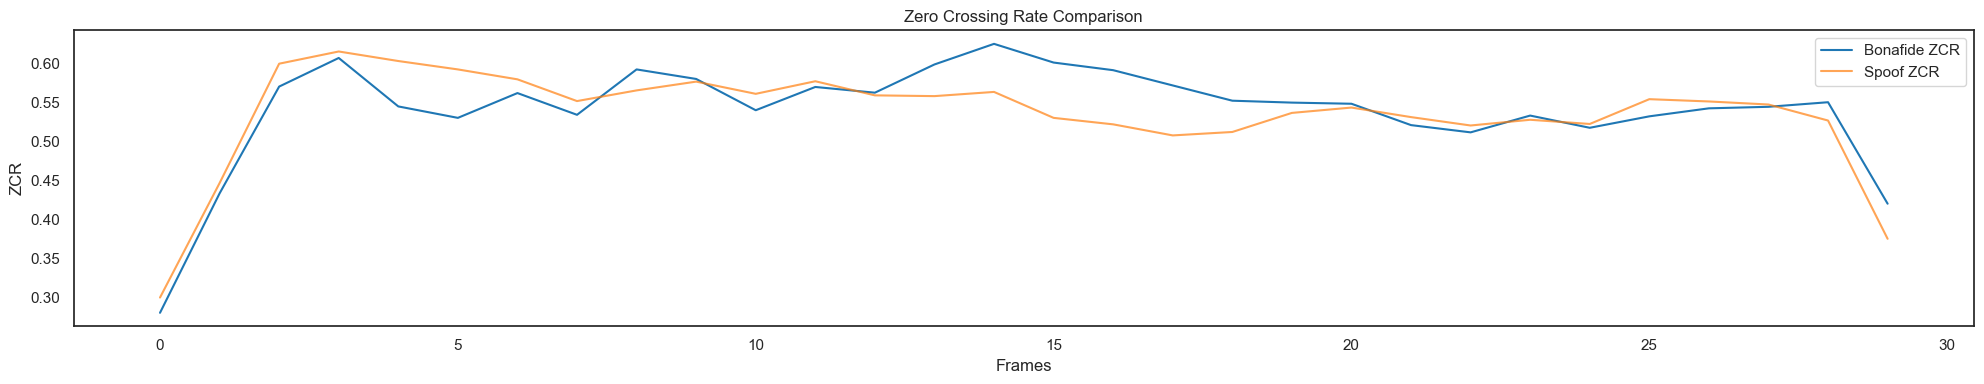

In [37]:
# 6. Zero Crossing Rate (ZCR)
zcr_bonafide = librosa.feature.zero_crossing_rate(bonafide_signal)
zcr_spoof = librosa.feature.zero_crossing_rate(spoof_signal)

plt.figure(figsize=(20, 4))
plt.plot(zcr_bonafide[0], label='Bonafide ZCR')
plt.plot(zcr_spoof[0], label='Spoof ZCR', alpha=0.7)
plt.title("Zero Crossing Rate Comparison")
plt.xlabel("Frames")
plt.ylabel("ZCR")
plt.legend()
plt.tight_layout()
plt.show()